In [27]:
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
import json
import torch
import numpy as np
import cv2
import random
import urllib.request
import zipfile
import io
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

In [ ]:
image_width = 256
image_height = 64
background_color = (255, 255, 255)
text_color = (0, 0, 0)

font_path = "/kaggle/input/robotomonofont/RobotoMono-Light.ttf"
font1 = ImageFont.truetype(font_path, size=36)
font2 = ImageFont.truetype("/kaggle/input/fonts3/Eater-Regular.ttf", size=36)
font3 = ImageFont.truetype("/kaggle/input/newfont5/BigShouldersStencil_18pt-ExtraBold.ttf", size=36)
font4 = ImageFont.truetype("/kaggle/input/fonts3/MysteryQuest-Regular.ttf", size=36)

# TASK 0

In [ ]:
words = [
    "Accountant", "Achieve", "Acrobat", "Activate", "Admiral", "Adversity",
    "Advocate", "Affluent", "Agitation", "Algorithm", "Allocate", "Alliance",
    "Ambiguous", "Amplitude", "Analyst", "Ancestor", "Animate", "Anomaly",
    "Antidote", "Aperture", "Applause", "Aquatic", "Arbitrary", "Archive",
    "Arduous", "Argument", "Armature", "Assembly", "Assertion", "Asteroid",
    "Attorney", "Audience", "Axiomatic", "Backpack", "Balance", "Ballistic",
    "Bankrupt", "Barrier", "Bilateral", "Birthday", "Blizzard", "Boundary",
    "Brochure", "Bulletin", "Burglary", "Business", "Bystander", "Calendar",
    "Campaign", "Capacity", "Captivate", "Carnival", "Catalyst", "Caution",
    "Celebrity", "Cemetery", "Ceremony", "Challenge", "Champion", "Chaos",
    "Charisma", "Chronicle", "Circular", "Citation", "Civilian", "Clarity",
    "Classify", "Coalition", "Cognitive", "Collusion", "Columnist", "Commerce",
    "Commitment", "Commodity", "Communique", "Compiler", "Complaint", "Composer",
    "Compound", "Compromise", "Compute", "Conceive", "Conclude", "Concrete",
    "Concur", "Condense", "Conduct", "Confide", "Confirm", "Conflict",
    "Conform", "Confound", "Congress", "Connect", "Conserve", "Consider",
    "Consist", "Console", "Consolidate", "Consort", "Constant", "Constitute",
    "Constrain", "Construct", "Consult", "Consume", "Contact", "Contain",
    "Contemplate", "Contend", "Content", "Contest", "Context", "Continue",
    "Contract", "Contrive", "Control", "Convene", "Converge", "Convert",
    "Convey", "Convict", "Convince", "Convolve", "Cooperate", "Coordinate"
]

# Easy Dataset Synthesis

In [ ]:
output_dir = "easy_set_images"
os.makedirs(output_dir, exist_ok=True)
fig, axes = plt.subplots(1, len(easy_words), figsize=(5 * len(easy_words), 5))
easy_dataset = {}
if len(easy_words) == 1:
    axes = [axes]  # Ensure axes is iterable if only one word

for i, word in enumerate(words):
    img = Image.new("RGB", (image_width, image_height), color=background_color)
    draw = ImageDraw.Draw(img)

    # Get bounding box
    bbox = draw.textbbox((0, 0), word, font=font1)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Center text
    text_x = (image_width - text_width) // 2
    text_y = (image_height - text_height) // 2

    # Draw text
    draw.text((text_x, text_y), word, fill=text_color, font=font1)

    # Save image
    output_path = os.path.join(output_dir, f"easy_{i+1}_{word}.png")
    img.save(output_path)
    easy_dataset[word] = output_path


print(f"Images saved in '{output_dir}' directory and displayed.")

# Hard Dataset Synthesis

In [ ]:
# Import necessary libraries

# Create output directory
output_dir = "hard_set_images"
os.makedirs(output_dir, exist_ok=True)
hard_dataset = {}

# Step 3: Define background generation functions
def create_noise_background(width, height, noise_type="gaussian"):
    """Create different types of noise backgrounds"""
    if noise_type == "gaussian":
        # Gaussian noise
        noise = np.random.normal(128, 10, (height, width, 3)).astype(np.uint8)
        return Image.fromarray(noise)

    elif noise_type== "coloured":
        if random.choice(["green", "red"]) == "green":
            noise = np.random.normal([0, 255, 0], 1, (height, width, 3)).astype(np.uint8)  # Green noise
        else:
            noise = np.random.normal([255, 0, 0], 1, (height, width, 3)).astype(np.uint8)  # Red noise
        return Image.fromarray(noise)
    
    elif noise_type == "gradient":
        # Gradient background
        gradient = np.zeros((height, width, 3), dtype=np.uint8)
        for y in range(height):
            for x in range(width):
                gradient[y, x] = [
                    int(200 + 55 * np.sin(0.1 * x + 0.05 * y)),
                    int(200 + 55 * np.sin(0.05 * x + 0.1 * y)),
                    int(200 + 55 * np.sin(0.15 * x + 0.15 * y))
                ]
        return Image.fromarray(gradient)

def create_textured_background(width, height):
    """Create a textured background with patterns"""
    # Create a base image
    img = np.ones((height, width, 3), dtype=np.uint8) * 240
    
    # Add random lines
    for _ in range(20):
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        color = (random.randint(180, 230), random.randint(180, 230), random.randint(180, 230))
        thickness = random.randint(1, 3)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    # Add random circles
    for _ in range(10):
        x, y = random.randint(0, width), random.randint(0, height)
        radius = random.randint(5, 20)
        color = (random.randint(180, 230), random.randint(180, 230), random.randint(180, 230))
        cv2.circle(img, (x, y), radius, color, -1)
    
    return Image.fromarray(img)

# Step 4: Generate Hard Set images
image_width, image_height = 300, 100  # Larger size for better visibility

for i, word in enumerate(words):
    iterw = word
    # 1. Select a random background type
    bg_type = random.choice(["gaussian", "gradient", "textured", "coloured"])
    if bg_type == "textured":
        img = create_textured_background(image_width, image_height)
    else:
        img = create_noise_background(image_width, image_height, bg_type)
    
    draw = ImageDraw.Draw(img)
    
    font = random.choice([font1, font2, font2, font3])
    
    # 3. Apply fluctuating capitalization
    fluctuated_word = ""
    for char in word:
        if random.random() > 0.5:
            fluctuated_word += char.upper()
        else:
            fluctuated_word += char.lower()
    
    # 4. Choose a random text color (ensuring contrast with background)
    text_color = (random.randint(0, 100), random.randint(0, 100), random.randint(0, 100))
    if bg_type == "coloured":
        text_colour = (0,0,0)

    # 5. Calculate text position (with slight randomization)

    bbox = draw.textbbox((0, 0), fluctuated_word, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x = (image_width - text_width) // 2 + random.randint(-10, 10)
    text_y = (image_height - text_height) // 2 + random.randint(-5, 5)
    
    # 6. Add slight rotation (optional)
    if random.random() > 0.7:
        # Create a new image for rotation
        txt = Image.new('RGBA', (text_width + 20, text_height + 20), (255, 255, 255, 0))
        d = ImageDraw.Draw(txt)
        d.text((10, 10), fluctuated_word, font=font, fill=text_color)
        angle = random.uniform(-10, 10)
        rotated = txt.rotate(angle, expand=True)
        
        # Paste rotated text onto background
        paste_x = max(0, (image_width - rotated.width) // 2)
        paste_y = max(0, (image_height - rotated.height) // 2)
        img.paste(rotated, (paste_x, paste_y), rotated)
    else:
        # Render text directly
        draw.text((text_x, text_y), fluctuated_word, fill=text_color, font=font)
    
    # 7. Save the image
    output_path = os.path.join(output_dir, f"hard_{i+1}_{iterw}.png")
    img.save(output_path)
    hard_dataset[iterw] = output_path
    print(output_path, bg_type)
    if i % 10 == 0:
        print(f"Generated {i} images")

print(f"Hard set images generated successfully in '{output_dir}'")

In [ ]:


# Path to the folder containing images
image_folder = "/kaggle/working/hard_set_images"

# Get a list of image files in the folder
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))])

# Check if there are images
if not image_files:
    print("No images found in the folder.")
else:
    # Set up a grid to display images
    num_images = len(image_files)
    cols = min(5, num_images)  # Max 5 images per row
    rows = (num_images + cols - 1) // cols  # Calculate required rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    # Flatten axes array for easy iteration (if more than 1 row)
    if rows > 1:
        axes = axes.ravel()
    else:
        axes = [axes]  # Make it iterable for a single row

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(img_name)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Bonus Dataset Synthesis

In [ ]:


# Create output directory
output_dir = "bonus_set_images"
os.makedirs(output_dir, exist_ok=True)
bonus_dataset = {}


# Step 3: Define background generation functions
def create_noise_background(width, height, noise_type="gaussian"):
    """Create different types of noise backgrounds"""
    if noise_type == "gaussian":
        # Gaussian noise
        noise = np.random.normal(128, 10, (height, width, 3)).astype(np.uint8)
        return Image.fromarray(noise), None  # No specific color

    elif noise_type == "coloured":
        col = random.choice(["green", "red"])
        if col == "green":
            noise = np.random.normal([0, 255, 0], 1, (height, width, 3)).astype(np.uint8)  # Green noise
        else:
            noise = np.random.normal([255, 0, 0], 1, (height, width, 3)).astype(np.uint8)  # Red noise
        return Image.fromarray(noise), col  # Return image and color

    elif noise_type == "gradient":
        # Gradient background
        gradient = np.zeros((height, width, 3), dtype=np.uint8)
        for y in range(height):
            for x in range(width):
                gradient[y, x] = [
                    int(200 + 55 * np.sin(0.1 * x + 0.05 * y)),
                    int(200 + 55 * np.sin(0.05 * x + 0.1 * y)),
                    int(200 + 55 * np.sin(0.15 * x + 0.15 * y))
                ]
        return Image.fromarray(gradient), None

def create_textured_background(width, height):
    """Create a textured background with patterns"""
    # Create a base image
    img = np.ones((height, width, 3), dtype=np.uint8) * 240

    # Add random lines
    for _ in range(20):
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        color = (random.randint(180, 230), random.randint(180, 230), random.randint(180, 230))
        thickness = random.randint(1, 3)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Add random circles
    for _ in range(10):
        x, y = random.randint(0, width), random.randint(0, height)
        radius = random.randint(5, 20)
        color = (random.randint(180, 230), random.randint(180, 230), random.randint(180, 230))
        cv2.circle(img, (x, y), radius, color, -1)

    return Image.fromarray(img), None

# Step 4: Generate Bonus Set images
image_width, image_height = 300, 100  # Larger size for better visibility

for i, word in enumerate(words):
    iterword = word  # Keep original word for naming
    
    # 1. Select a random background type
    bg_type = random.choice(["gaussian", "gradient", "textured", "coloured"])
    
    if bg_type == "textured":
        img, bg_col = create_textured_background(image_width, image_height)
    else:
        img, bg_col = create_noise_background(image_width, image_height, bg_type)
    
    draw = ImageDraw.Draw(img)
    
    font = random.choice([font1, font2, font3, font4])

    # Bonus logic: Reverse word if red background
    if bg_type == "coloured" and bg_col == "red":
        word = word[::-1]

    # 3. Apply fluctuating capitalization
    fluctuated_word = "".join(
        char.upper() if random.random() > 0.5 else char.lower() for char in word
    )

    # 4. Choose a random text color (ensuring contrast with background)
    text_color = (random.randint(0, 100), random.randint(0, 100), random.randint(0, 100))
    if bg_type == "coloured":
        text_color = (0, 0, 0)  # Always black on coloured backgrounds for visibility

    # 5. Calculate text position (with slight randomization)
    bbox = draw.textbbox((0, 0), fluctuated_word, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x = (image_width - text_width) // 2 + random.randint(-10, 10)
    text_y = (image_height - text_height) // 2 + random.randint(-5, 5)

    # 6. Add slight rotation (optional)
    if random.random() > 0.7:
        txt = Image.new('RGBA', (text_width + 20, text_height + 20), (255, 255, 255, 0))
        d = ImageDraw.Draw(txt)
        d.text((10, 10), fluctuated_word, font=font, fill=text_color)
        angle = random.uniform(-10, 10)
        rotated = txt.rotate(angle, expand=True)
        img.paste(rotated, ((image_width - rotated.width) // 2, (image_height - rotated.height) // 2), rotated)
    else:
        draw.text((text_x, text_y), fluctuated_word, fill=text_color, font=font)

    # 7. Save the image
    output_path = os.path.join(output_dir, f"bonus_{i+1}_{iterword}.png")
    img.save(output_path)
    bonus_dataset[iterword] = output_path
    print(f"Generated: {iterword} - {bg_type}")

print(f"Bonus set images generated successfully in '{output_dir}'")

In [ ]:


# Path to the folder containing images
image_folder = "/kaggle/working/bonus_set_images"

# Get a list of image files in the folder
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".jpeg"))])

# Check if there are images
if not image_files:
    print("No images found in the folder.")
else:
    # Set up a grid to display images
    num_images = len(image_files)
    cols = min(5, num_images)  # Max 5 images per row
    rows = (num_images + cols - 1) // cols  # Calculate required rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    # Flatten axes array for easy iteration (if more than 1 row)
    if rows > 1:
        axes = axes.ravel()
    else:
        axes = [axes]  # Make it iterable for a single row

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(img_name)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:

# with open('easy.json', 'w') as f:
#     json.dump(easy_dataset, f)

# with open('hard.json', 'w') as f:
#     json.dump(hard_dataset, f)

with open('bonus.json', 'w') as f:
    json.dump(bonus_dataset, f)

# TASK 1

In [ ]:
import json
import os

def load_json_file(filename):
    """Loads a JSON file and handles errors gracefully."""
    if not os.path.exists(filename):
        print(f"Warning: {filename} not found!")
        return {}  # Return an empty dictionary if file is missing

    if os.path.getsize(filename) == 0:
        print(f"Warning: {filename} is empty!")
        return {}  # Return empty dictionary for empty file

    try:
        with open(filename, "r") as file:
            return json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error loading {filename}: {e}")
        return {}  # Return empty dictionary if JSON is malformed

# Load all datasets safely
easy_dataset = load_json_file("easy.json")
hard_dataset = load_json_file("hard.json")
bonus_dataset = load_json_file("bonus.json")

# Optional: Print summary
print(f"Easy dataset loaded with {len(easy_dataset)} items")
print(f"Hard dataset loaded with {len(hard_dataset)} items")
print(f"Bonus dataset loaded with {len(bonus_dataset)} items")

In [ ]:
selected_words = words[:100]

selected_easy_dataset = {}
selected_hard_dataset = {}
selected_bonus_dataset = {}

for w in selected_words:
    selected_easy_dataset[w] = easy_dataset[w]
    selected_hard_dataset[w] = hard_dataset[w]
    selected_bonus_dataset[w] = bonus_dataset[w]

## Preprocessing and Dataset Class

In [ ]:
dataset_info = []
for word, path in selected_easy_dataset.items():
    dataset_info.append({'image_path': path, 'label': word, 'set': 'easy'})
for word, path in selected_hard_dataset.items():
    dataset_info.append({'image_path': path, 'label': word, 'set': 'hard'})
print("Total samples:", len(dataset_info))

In [29]:
transform = transforms.Compose([transforms.Resize((64, 256)),transforms.ToTensor(),transforms.Lambda(lambda x: x / 255.0 if x.max() > 1 else x)])

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        labels = [item['label'] for item in data]
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.encoded_labels[idx]
        return image, label

custom_dataset = CustomImageDataset(data=dataset_info, transform=transform)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)
for images, labels in dataloader:
    print("Batch image tensor shape:", images.shape)
    print("Batch labels:", labels)
    break

Batch image tensor shape: torch.Size([32, 3, 64, 256])
Batch labels: tensor([58, 64, 84, 69, 92, 39, 99, 89, 65, 15,  9,  1, 94, 41, 49, 43, 72, 75,
        23, 98, 83, 78, 47,  0, 79,  3, 40, 60, 74, 55, 15, 82])


# Model

In [30]:
class SmallEnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallEnhancedCNN, self).__init__()
        
        # Initial convolutional layer: 3 -> 32 channels.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        
        # Residual Block: Increase channels from 32 to 64.
        self.res_conv = nn.Conv2d(32, 64, kernel_size=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Spatial Attention mechanism
        self.attention_conv = nn.Conv2d(64, 1, kernel_size=1)
        
        # Multi-scale feature extraction:
        self.multi_scale_convs = nn.ModuleList([
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 3x3
            nn.Conv2d(64, 32, kernel_size=5, padding=2),  # 5x5
            nn.Conv2d(64, 32, kernel_size=7, padding=3)   # 7x7
        ])
        
        # Classification head: combined channels = 32+32+32+64 = 160
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, num_classes)
    
    def forward(self, x):
        # Initial conv
        out = self.relu(self.bn1(self.conv1(x)))  # (B, 32, H, W)
        
        # Residual block
        residual = self.res_conv(out)  # (B, 64, H, W)
        out_block = self.relu(self.bn2(self.conv2(out)))  # (B, 64, H, W)
        out_block = self.bn3(self.conv3(out_block))         # (B, 64, H, W)
        out_block = self.relu(out_block + residual)
        
        # Pooling
        out_pool = self.pool(out_block)  # (B, 64, H/2, W/2)
        
        # Spatial attention
        attention_map = torch.sigmoid(self.attention_conv(out_pool))  # (B, 1, H/2, W/2)
        out_att = out_pool * attention_map
        
        # Multi-scale feature extraction
        multi_scale_feats = [self.relu(conv(out_att)) for conv in self.multi_scale_convs]
        multi_scale_feats.append(out_att)  # original features: (B, 64, H/2, W/2)
        combined_feats = torch.cat(multi_scale_feats, dim=1)  # (B, 160, H/2, W/2)
        
        # Global average pooling to (B, 160)
        gap = F.adaptive_avg_pool2d(combined_feats, (1, 1)).view(x.size(0), -1)
        
        # Classification
        gap = self.dropout(gap)
        logits = self.fc(gap)
        return logits

# Model training

In [31]:
def train_model(model, train_loader, val_loader, epochs, lr, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss = running_loss / total
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'val_accuracy': val_acc,
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }
    return metrics

In [32]:
full_dataset = CustomImageDataset(data=dataset_info, transform=transform)
train_ratio = 0.7
val_ratio = 0.15

easy_samples = [sample for sample in dataset_info if sample['set'] == 'easy']
hard_samples = [sample for sample in dataset_info if sample['set'] == 'hard']

def split_subset(samples, train_ratio):
    train_samples, temp_samples = train_test_split(samples, test_size=(1 - train_ratio), random_state=42)
    val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)
    return train_samples, val_samples, test_samples

train_easy, val_easy, test_easy = split_subset(easy_samples, train_ratio)
train_hard, val_hard, test_hard = split_subset(hard_samples, train_ratio)

train_set = train_easy + train_hard
val_set   = val_easy   + val_hard
test_set  = test_easy  + test_hard

random.shuffle(train_set)
random.shuffle(val_set)
random.shuffle(test_set)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

# 1) Gather all labels from the entire dataset
all_labels = [item['label'] for item in dataset_info]

# 2) Fit a single label encoder
global_label_encoder = LabelEncoder()
global_label_encoder.fit(all_labels)

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None, label_encoder=None):
        self.data = data
        self.transform = transform
        self.label_encoder = label_encoder   # do NOT fit again here
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Use the global label encoder to transform the label
        label = self.label_encoder.transform([sample['label']])[0]
        return image, label

# 3) Now create each dataset with the SAME encoder
train_dataset = CustomImageDataset(train_set, transform=transform, label_encoder=global_label_encoder)
val_dataset   = CustomImageDataset(val_set,   transform=transform, label_encoder=global_label_encoder)
test_dataset  = CustomImageDataset(test_set,  transform=transform, label_encoder=global_label_encoder)

Train set size: 138
Validation set size: 30
Test set size: 32


In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Hyperparameter Tuning

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define hyperparameter grid
learning_rates = [1e-3, 1e-4]
batch_sizes = [32, 64]
epochs = 100  # for quick experimentation; increase for full training

# For sample size experiments, we try subsets of the training set.
sample_percentages = [0.1, 0.3, 0.5, 1.0]

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for sample_pct in sample_percentages:
            # Subsample the training dataset
            num_samples = int(len(train_dataset) * sample_pct)
            indices = list(range(len(train_dataset)))
            random.shuffle(indices)
            selected_indices = indices[:num_samples]
            train_subset = Subset(train_dataset, selected_indices)
            
            # Create DataLoaders for the current hyperparameter configuration
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize a new instance of the model
            model = SmallEnhancedCNN(num_classes=100).to(device)
            print(f"\nTraining with lr={lr}, batch_size={batch_size}, sample_pct={sample_pct}")
            metrics = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, device=device)
            
            # Store configuration and results
            results.append({
                'lr': lr,
                'batch_size': batch_size,
                'sample_pct': sample_pct,
                'metrics': metrics,
                'num_params': count_parameters(model)
            })

Using device: cuda

Training with lr=0.001, batch_size=32, sample_pct=0.1
Epoch [1/100] Train Loss: 4.7079, Train Acc: 0.00% | Val Loss: 4.6157, Val Acc: 0.00%
Epoch [2/100] Train Loss: 4.3874, Train Acc: 7.69% | Val Loss: 4.6284, Val Acc: 0.00%
Epoch [3/100] Train Loss: 4.0400, Train Acc: 23.08% | Val Loss: 4.6425, Val Acc: 0.00%
Epoch [4/100] Train Loss: 3.8407, Train Acc: 0.00% | Val Loss: 4.6545, Val Acc: 0.00%
Epoch [5/100] Train Loss: 3.5599, Train Acc: 15.38% | Val Loss: 4.6687, Val Acc: 0.00%
Epoch [6/100] Train Loss: 3.2231, Train Acc: 30.77% | Val Loss: 4.6882, Val Acc: 0.00%
Epoch [7/100] Train Loss: 2.9816, Train Acc: 23.08% | Val Loss: 4.7126, Val Acc: 0.00%
Epoch [8/100] Train Loss: 2.9930, Train Acc: 15.38% | Val Loss: 4.7451, Val Acc: 0.00%
Epoch [9/100] Train Loss: 3.0377, Train Acc: 7.69% | Val Loss: 4.7826, Val Acc: 0.00%
Epoch [10/100] Train Loss: 2.7942, Train Acc: 15.38% | Val Loss: 4.8343, Val Acc: 0.00%
Epoch [11/100] Train Loss: 2.7167, Train Acc: 23.08% | Val 

In [24]:
from collections import Counter
train_labels = [s['label'] for s in train_set]
val_labels   = [s['label'] for s in val_set]
print("Train distribution:", Counter(train_labels))
print("Val distribution:  ", Counter(val_labels))

Train distribution: Counter({'Concur': 2, 'Bilateral': 2, 'Catalyst': 2, 'Conserve': 2, 'Barrier': 2, 'Ceremony': 2, 'Communique': 2, 'Conflict': 2, 'Advocate': 2, 'Conceive': 2, 'Challenge': 2, 'Argument': 2, 'Balance': 2, 'Circular': 2, 'Affluent': 2, 'Amplitude': 2, 'Charisma': 2, 'Capacity': 2, 'Bystander': 2, 'Aperture': 2, 'Champion': 2, 'Consolidate': 2, 'Boundary': 2, 'Civilian': 2, 'Arduous': 2, 'Condense': 2, 'Conduct': 2, 'Ballistic': 2, 'Coalition': 2, 'Connect': 2, 'Adversity': 2, 'Acrobat': 2, 'Citation': 2, 'Carnival': 2, 'Conclude': 2, 'Axiomatic': 2, 'Confound': 2, 'Bulletin': 2, 'Console': 2, 'Assertion': 2, 'Chronicle': 2, 'Archive': 2, 'Aquatic': 2, 'Captivate': 2, 'Classify': 2, 'Anomaly': 2, 'Consider': 2, 'Congress': 2, 'Chaos': 2, 'Consort': 2, 'Clarity': 2, 'Campaign': 2, 'Achieve': 2, 'Bankrupt': 2, 'Compiler': 2, 'Activate': 2, 'Animate': 2, 'Agitation': 2, 'Assembly': 2, 'Analyst': 2, 'Commerce': 2, 'Applause': 2, 'Confide': 2, 'Celebrity': 2, 'Cognitive': 2

In [25]:
unique_train_words = set([s['label'] for s in train_set])
unique_val_words   = set([s['label'] for s in val_set])
missing_in_val = unique_train_words - unique_val_words
print("Words in train but not in val:", missing_in_val)

Words in train but not in val: {'Applause', 'Anomaly', 'Consider', 'Congress', 'Ballistic', 'Bankrupt', 'Affluent', 'Classify', 'Conflict', 'Challenge', 'Campaign', 'Catalyst', 'Chronicle', 'Barrier', 'Ceremony', 'Argument', 'Citation', 'Chaos', 'Conserve', 'Concur', 'Capacity', 'Agitation', 'Assertion', 'Balance', 'Conduct', 'Asteroid', 'Communique', 'Compromise', 'Boundary', 'Compound', 'Cognitive', 'Axiomatic', 'Activate', 'Consolidate', 'Consort', 'Clarity', 'Civilian', 'Acrobat', 'Captivate', 'Confound', 'Assembly', 'Advocate', 'Carnival', 'Adversity', 'Condense', 'Compiler', 'Animate', 'Coalition', 'Aquatic', 'Archive', 'Commerce', 'Celebrity', 'Connect', 'Analyst', 'Arduous', 'Conceive', 'Console', 'Calendar', 'Bystander', 'Charisma', 'Confide', 'Circular', 'Amplitude', 'Achieve', 'Champion', 'Bilateral', 'Aperture', 'Conclude', 'Bulletin'}


# Scientific Reporting and Plotting

----------------------------------------------------
LR: 0.001, Batch Size: 32, Sample %: 0.1
Final Val Accuracy: 0.00%
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Total trainable parameters: 244997
----------------------------------------------------
----------------------------------------------------
LR: 0.001, Batch Size: 32, Sample %: 0.3
Final Val Accuracy: 0.00%
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Total trainable parameters: 244997
----------------------------------------------------
----------------------------------------------------
LR: 0.001, Batch Size: 32, Sample %: 0.5
Final Val Accuracy: 0.00%
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Total trainable parameters: 244997
----------------------------------------------------
----------------------------------------------------
LR: 0.001, Batch Size: 32, Sample %: 1.0
Final Val Accuracy: 0.00%
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Total trainable parameters: 244997
-------------------------------------

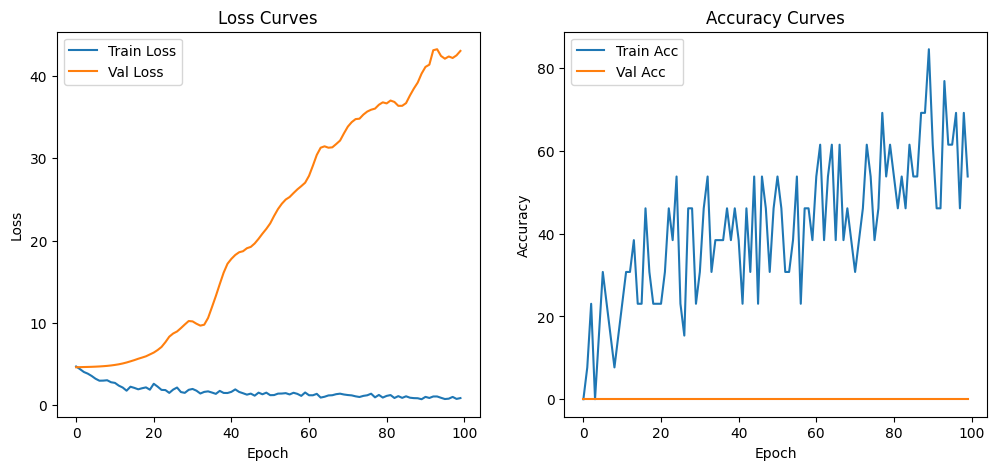

In [35]:
for res in results:
    print("----------------------------------------------------")
    print(f"LR: {res['lr']}, Batch Size: {res['batch_size']}, Sample %: {res['sample_pct']}")
    print(f"Final Val Accuracy: {res['metrics']['val_accuracy']:.2f}%")
    print(f"Precision: {res['metrics']['precision']:.4f}, Recall: {res['metrics']['recall']:.4f}, F1: {res['metrics']['f1']:.4f}")
    print(f"Total trainable parameters: {res['num_params']}")
    print("----------------------------------------------------")

# Optionally, plot learning curves for one experiment (for demonstration):
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results[0]['metrics']['train_losses'], label='Train Loss')
plt.plot(results[0]['metrics']['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results[0]['metrics']['train_accs'], label='Train Acc')
plt.plot(results[0]['metrics']['val_accs'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

In [36]:
import random
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

# ============
# Step 1: Build the Dataset Info
# ============
# Assume you have dictionaries mapping words to image paths.
# For example:
#   easy_dataset = { 'apple': '/path/to/easy/apple.png', ... }
#   hard_dataset = { 'apple': '/path/to/hard/apple.png', ... }
#   bonus_dataset = { ... }  (unused here)
# We select the first 100 words.
selected_words = words[:100]

selected_easy_dataset = {w: easy_dataset[w] for w in selected_words}
selected_hard_dataset = {w: hard_dataset[w] for w in selected_words}
# We ignore bonus_dataset for this example.

# Create a unified list of samples.
dataset_info = []
for word, path in selected_easy_dataset.items():
    dataset_info.append({'image_path': path, 'label': word, 'set': 'easy'})
for word, path in selected_hard_dataset.items():
    dataset_info.append({'image_path': path, 'label': word, 'set': 'hard'})

print("Total samples:", len(dataset_info))
# If you have 1 sample per set per word, expect ~200 samples (2 per class).

# ============
# Step 2: Define Transformations and Custom Dataset Class
# ============
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0 if x.max() > 1 else x)
])

# Create a global label encoder using all labels.
all_labels = [sample['label'] for sample in dataset_info]
global_label_encoder = LabelEncoder()
global_label_encoder.fit(all_labels)

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None, label_encoder=None):
        """
        Args:
            data (list): List of dicts with keys 'image_path', 'label', 'set'
            transform (callable, optional): Transformations to apply.
            label_encoder (LabelEncoder): A pre-fit LabelEncoder.
        """
        self.data = data
        self.transform = transform
        self.label_encoder = label_encoder
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Use the global encoder to transform the label.
        label = self.label_encoder.transform([sample['label']])[0]
        return image, label

# ============
# Step 3: Cross-Validation with StratifiedKFold
# ============
# Because you don't have 3 samples per class, we'll use StratifiedKFold with n_splits=2.
labels = [sample['label'] for sample in dataset_info]
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

fold_results = []
fold_idx = 1
for train_index, val_index in skf.split(dataset_info, labels):
    print(f"\n--- Fold {fold_idx} ---")
    train_samples = [dataset_info[i] for i in train_index]
    val_samples   = [dataset_info[i] for i in val_index]
    
    # Optional: Check distribution for this fold.
    unique_train = set([s['label'] for s in train_samples])
    unique_val = set([s['label'] for s in val_samples])
    missing_in_val = unique_train - unique_val
    print("Words in train but not in val:", missing_in_val)
    
    # Create dataset objects using the same global label encoder.
    train_dataset = CustomImageDataset(train_samples, transform=transform, label_encoder=global_label_encoder)
    val_dataset = CustomImageDataset(val_samples, transform=transform, label_encoder=global_label_encoder)
    
    # Create DataLoaders.
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # ============
    # (Optional) Step 4: Define a Model (SmallEnhancedCNN)
    # ============
    class SmallEnhancedCNN(nn.Module):
        def __init__(self, num_classes):
            super(SmallEnhancedCNN, self).__init__()
            
            # Initial convolutional layer: 3 -> 32 channels.
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.relu = nn.ReLU()
            
            # Residual Block: Increase channels from 32 to 64.
            self.res_conv = nn.Conv2d(32, 64, kernel_size=1)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(64)
            
            # Pooling layer.
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            
            # Spatial Attention mechanism.
            self.attention_conv = nn.Conv2d(64, 1, kernel_size=1)
            
            # Multi-scale feature extraction.
            self.multi_scale_convs = nn.ModuleList([
                nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 3x3
                nn.Conv2d(64, 32, kernel_size=5, padding=2),  # 5x5
                nn.Conv2d(64, 32, kernel_size=7, padding=3)   # 7x7
            ])
            
            # Classification head: combined channels = 32+32+32+64 = 160.
            self.dropout = nn.Dropout(0.5)
            self.fc = nn.Linear(160, num_classes)
        
        def forward(self, x):
            out = self.relu(self.bn1(self.conv1(x)))  # (B, 32, H, W)
            residual = self.res_conv(out)             # (B, 64, H, W)
            out_block = self.relu(self.bn2(self.conv2(out)))  # (B, 64, H, W)
            out_block = self.bn3(self.conv3(out_block))         # (B, 64, H, W)
            out_block = self.relu(out_block + residual)         # Residual connection.
            out_pool = self.pool(out_block)             # (B, 64, H/2, W/2)
            attention_map = torch.sigmoid(self.attention_conv(out_pool))  # (B, 1, H/2, W/2)
            out_att = out_pool * attention_map          # Apply attention.
            # Multi-scale features.
            multi_scale_feats = [self.relu(conv(out_att)) for conv in self.multi_scale_convs]
            multi_scale_feats.append(out_att)           # Include original features.
            combined_feats = torch.cat(multi_scale_feats, dim=1)  # (B, 160, H/2, W/2)
            gap = F.adaptive_avg_pool2d(combined_feats, (1, 1)).view(x.size(0), -1)  # (B, 160)
            gap = self.dropout(gap)
            logits = self.fc(gap)
            return logits

    # ============
    # (Optional) Step 5: Define Training Loop for This Fold
    # ============
    def train_model(model, train_loader, val_loader, epochs, lr, device):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        for epoch in range(epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            train_loss = running_loss / total
            train_acc = 100 * correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            model.eval()
            running_loss, correct, total = 0.0, 0, 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            val_loss = running_loss / total
            val_acc = 100 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        return {'train_losses': train_losses, 'val_losses': val_losses,
                'train_accs': train_accs, 'val_accs': val_accs, 'final_val_acc': val_acc}
    
    # ============
    # Train the model for this fold.
    # ============
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SmallEnhancedCNN(num_classes=100).to(device)
    metrics = train_model(model, train_loader, val_loader, epochs=100, lr=1e-3, device=device)
    fold_results.append(metrics)
    fold_idx += 1

# After cross-validation, you can average the metrics from each fold.
avg_val_acc = sum([res['final_val_acc'] for res in fold_results]) / len(fold_results)
print("\nAverage Validation Accuracy across folds:", avg_val_acc)


Total samples: 200

--- Fold 1 ---
Words in train but not in val: set()
Epoch [10/100] Train Acc: 1.00% | Val Acc: 0.00%
Epoch [20/100] Train Acc: 8.00% | Val Acc: 0.00%
Epoch [30/100] Train Acc: 3.00% | Val Acc: 0.00%
Epoch [40/100] Train Acc: 4.00% | Val Acc: 0.00%
Epoch [50/100] Train Acc: 5.00% | Val Acc: 0.00%
Epoch [60/100] Train Acc: 7.00% | Val Acc: 0.00%
Epoch [70/100] Train Acc: 7.00% | Val Acc: 0.00%
Epoch [80/100] Train Acc: 15.00% | Val Acc: 0.00%
Epoch [90/100] Train Acc: 2.00% | Val Acc: 0.00%
Epoch [100/100] Train Acc: 5.00% | Val Acc: 0.00%

--- Fold 2 ---
Words in train but not in val: set()
Epoch [10/100] Train Acc: 6.00% | Val Acc: 0.00%
Epoch [20/100] Train Acc: 6.00% | Val Acc: 1.00%
Epoch [30/100] Train Acc: 7.00% | Val Acc: 1.00%
Epoch [40/100] Train Acc: 7.00% | Val Acc: 1.00%
Epoch [50/100] Train Acc: 7.00% | Val Acc: 0.00%
Epoch [60/100] Train Acc: 7.00% | Val Acc: 1.00%
Epoch [70/100] Train Acc: 6.00% | Val Acc: 1.00%
Epoch [80/100] Train Acc: 6.00% | Val Ac

# TASK 1 : Generation

In [38]:
character_set = "0123456789abcdefghijklmnopqrstuvwxyz"
char_to_index = {char: i+1 for i, char in enumerate(character_set)}  # 1..len(chars)
index_to_char = {i+1: char for char, i in char_to_index.items()}
num_chars = len(character_set) + 1  # +1 for the blank token
class OCRDataset(Dataset):
    def __init__(self, data, transform=None, char_to_index=None):
        """
        Args:
            data (list): Each element is a dict with keys:
                - 'image_path': Path to the image file.
                - 'label': The full text/word for that image.
            transform (callable, optional): Transformations to apply on the PIL image.
            char_to_index (dict): Mapping from character to integer index.
        """
        self.data = data
        self.transform = transform
        self.char_to_index = char_to_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image_path = sample['image_path']
        text = sample['label'].lower()
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Encode text into indices
        # If a character is not in char_to_index, we skip or map to blank (0).
        target_indices = [self.char_to_index.get(ch, 0) for ch in text]
        
        # Convert to torch tensor
        target_tensor = torch.tensor(target_indices, dtype=torch.long)
        
        return image, target_tensor
# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 256)),       # Example size, adjust as needed
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0 if x.max() > 1 else x)
])

# Create the 3 dataset objects
train_dataset = OCRDataset(train_set, transform=transform, char_to_index=char_to_index)
val_dataset   = OCRDataset(val_set,   transform=transform, char_to_index=char_to_index)
test_dataset  = OCRDataset(test_set,  transform=transform, char_to_index=char_to_index)
def ocr_collate_fn(batch):
    """
    batch: list of (image_tensor, target_tensor) pairs
    We return:
      - images: (B, 3, H, W)
      - targets: list of length B, each is a 1D tensor of character indices
    """
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    # targets remain a tuple of 1D tensors
    return images, list(targets)

# Example DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=ocr_collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, collate_fn=ocr_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, collate_fn=ocr_collate_fn)


# Model

In [39]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, hidden_size=256):
        """
        Args:
            img_height (int): The height of the input images (e.g., 64).
            num_channels (int): The number of channels in input images (3 for RGB).
            num_classes (int): Number of output classes (including the CTC blank).
            hidden_size (int): Dimensionality of LSTM hidden state.
        """
        super(CRNN, self).__init__()
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),  # (B,64,H,W)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # -> (B,64,H/2,W/2)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # -> (B,128,H/4,W/4)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # -> (B,256,H/8,W/4)

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))   # -> (B,512,H/16,W/4)
        )
        
        self.rnn1 = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        """
        x: (B, 3, H, W)
        returns: (T, B, num_classes)  # for CTCLoss
        """
        conv_out = self.cnn(x)  # shape: (B, 512, H', W')
        b, c, h, w = conv_out.size()
        
        # We want the height dimension to be 1 ideally; if h != 1, we can pool or do adaptive_avg_pool.
        if h != 1:
            conv_out = F.adaptive_avg_pool2d(conv_out, (1, w))
            b, c, h, w = conv_out.size()  # now h should be 1
        
        # (B, c, 1, w) -> (B, c, w)
        conv_out = conv_out.squeeze(2)  # remove height dimension -> (B, 512, w)
        # Transpose to (B, w, 512) so w acts like "time"
        conv_out = conv_out.permute(0, 2, 1)  # (B, w, c=512)
        
        # Pass through RNN layers
        rnn_out, _ = self.rnn1(conv_out)  # (B, w, hidden_size*2)
        rnn_out, _ = self.rnn2(rnn_out)   # (B, w, hidden_size*2)
        
        # FC -> (B, w, num_classes)
        logits = self.fc(rnn_out)
        
        # For CTCLoss, we need shape (T, B, num_classes)
        logits = logits.permute(1, 0, 2)  # (w, B, num_classes)
        return logits


In [40]:
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
def greedy_decode(logits, blank=0):
    """
    logits: (T, B, num_classes)
    returns: list of predicted strings
    """
    max_indices = torch.argmax(logits, dim=2)  # (T, B)
    max_indices = max_indices.transpose(0, 1)  # (B, T)
    
    results = []
    for seq in max_indices:
        prev = blank
        decoded = []
        for idx in seq:
            idx = idx.item()
            if idx != blank and idx != prev:
                decoded.append(index_to_char.get(idx, ''))
            prev = idx
        results.append("".join(decoded))
    return results
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_samples = 0
    
    for images, targets in loader:
        images = images.to(device)
        
        # Prepare for CTC
        # 1) Concatenate targets into one tensor
        target_lengths = [len(t) for t in targets]  # list of ints
        targets_concat = torch.cat(targets, dim=0).to(device)  # 1D tensor
        batch_size = images.size(0)
        
        # 2) Forward pass
        logits = model(images)  # (T, B, num_classes)
        log_probs = F.log_softmax(logits, dim=2)
        T = logits.size(0)  # "time" dimension
        input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long).to(device)
        target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)
        
        # 3) Compute CTC loss
        loss = criterion(log_probs, targets_concat, input_lengths, target_lengths)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    return total_loss / total_samples
def validate(model, loader, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            target_lengths = [len(t) for t in targets]
            targets_concat = torch.cat(targets, dim=0).to(device)
            batch_size = images.size(0)
            
            logits = model(images)
            log_probs = F.log_softmax(logits, dim=2)
            T = logits.size(0)
            input_lengths = torch.full(size=(batch_size,), fill_value=T, dtype=torch.long).to(device)
            target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)
            
            loss = criterion(log_probs, targets_concat, input_lengths, target_lengths)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Decode predictions
            preds = greedy_decode(logits, blank=0)
            all_preds.extend(preds)
            
            # Convert numeric targets back to string for comparison
            for t in targets:
                chars = []
                for idx in t:
                    if idx.item() != 0:  # skip blank
                        chars.append(index_to_char.get(idx.item(), ''))
                all_targets.append("".join(chars))
    
    avg_loss = total_loss / total_samples
    
    # Compute word-level accuracy
    correct = sum([1 for p, t in zip(all_preds, all_targets) if p == t])
    word_acc = 100.0 * correct / len(all_targets)
    
    return avg_loss, word_acc, all_preds, all_targets


Using device: cuda
Epoch 1/50: Train Loss=8.5746, Val Loss=3.4411, Val Word Acc=0.00%
Epoch 2/50: Train Loss=3.2920, Val Loss=3.1602, Val Word Acc=0.00%
Epoch 3/50: Train Loss=3.1309, Val Loss=3.1268, Val Word Acc=0.00%
Epoch 4/50: Train Loss=3.0645, Val Loss=3.1422, Val Word Acc=0.00%
Epoch 5/50: Train Loss=3.0363, Val Loss=3.1182, Val Word Acc=0.00%
Epoch 6/50: Train Loss=3.0042, Val Loss=3.0882, Val Word Acc=0.00%
Epoch 7/50: Train Loss=2.9687, Val Loss=3.0587, Val Word Acc=0.00%
Epoch 8/50: Train Loss=2.9263, Val Loss=3.0150, Val Word Acc=0.00%
Epoch 9/50: Train Loss=2.8816, Val Loss=2.9985, Val Word Acc=0.00%
Epoch 10/50: Train Loss=2.8352, Val Loss=2.9511, Val Word Acc=0.00%
Epoch 11/50: Train Loss=2.8053, Val Loss=2.9575, Val Word Acc=0.00%
Epoch 12/50: Train Loss=2.7816, Val Loss=2.9368, Val Word Acc=0.00%
Epoch 13/50: Train Loss=2.7688, Val Loss=2.9296, Val Word Acc=0.00%
Epoch 14/50: Train Loss=2.7547, Val Loss=2.9292, Val Word Acc=0.00%
Epoch 15/50: Train Loss=2.7350, Val Lo

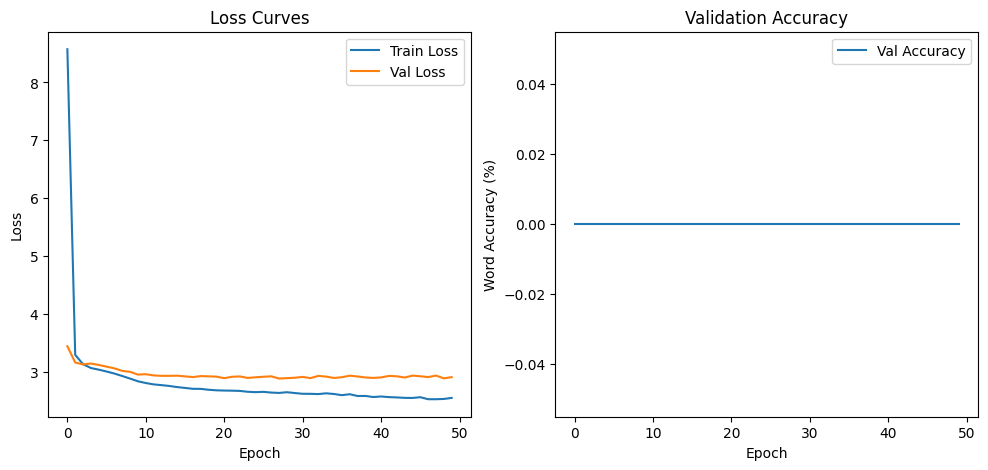


Test Loss: 2.7387, Test Word Accuracy: 0.00%

Sample Predictions:
GT: bnllhsldms | Predicted: b9d
GT: ahqsgc9x | Predicted: bnsd
GT: bnmrhrs | Predicted: bnd
GT: bnllnchsx | Predicted: bnmd
GT: bnmrhrs | Predicted: bnd


In [41]:
####################
# MAIN TRAINING LOOP
####################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Build CRNN model
img_height = 64
num_channels = 3
hidden_size = 256
model = CRNN(img_height, num_channels, num_chars, hidden_size=hidden_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    tr_loss = train_one_epoch(model, train_loader, optimizer, device)
    v_loss, v_acc, v_preds, v_targets = validate(model, val_loader, device)
    
    train_losses.append(tr_loss)
    val_losses.append(v_loss)
    val_accuracies.append(v_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={tr_loss:.4f}, "
          f"Val Loss={v_loss:.4f}, "
          f"Val Word Acc={v_acc:.2f}%")

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Word Accuracy (%)')
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Evaluate on the test set
test_loss, test_acc, test_preds, test_targets = validate(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Word Accuracy: {test_acc:.2f}%")

# Print a few sample predictions
print("\nSample Predictions:")
for i in range(min(5, len(test_preds))):
    print(f"GT: {test_targets[i]} | Predicted: {test_preds[i]}")


Total samples: 200
Train set size: 138
Validation set size: 30
Test set size: 32
Using device: cuda
Epoch 1/50: Train Loss=8.4349, Val Loss=3.2770, Val Word Acc=0.00%, Val CER=1.0000
Epoch 2/50: Train Loss=3.2731, Val Loss=3.1821, Val Word Acc=0.00%, Val CER=1.0000
Epoch 3/50: Train Loss=3.1488, Val Loss=3.1419, Val Word Acc=0.00%, Val CER=1.0000
Epoch 4/50: Train Loss=3.0849, Val Loss=3.1459, Val Word Acc=0.00%, Val CER=1.0000
Epoch 5/50: Train Loss=3.0625, Val Loss=3.1381, Val Word Acc=0.00%, Val CER=1.0000
Epoch 6/50: Train Loss=3.0353, Val Loss=3.1087, Val Word Acc=0.00%, Val CER=1.0000
Epoch 7/50: Train Loss=3.0110, Val Loss=3.0961, Val Word Acc=0.00%, Val CER=1.0000
Epoch 8/50: Train Loss=2.9888, Val Loss=3.0881, Val Word Acc=0.00%, Val CER=1.0000
Epoch 9/50: Train Loss=2.9621, Val Loss=3.0627, Val Word Acc=0.00%, Val CER=1.0000
Epoch 10/50: Train Loss=2.9248, Val Loss=3.0326, Val Word Acc=0.00%, Val CER=1.0000
Epoch 11/50: Train Loss=2.8889, Val Loss=3.0067, Val Word Acc=0.00%, 

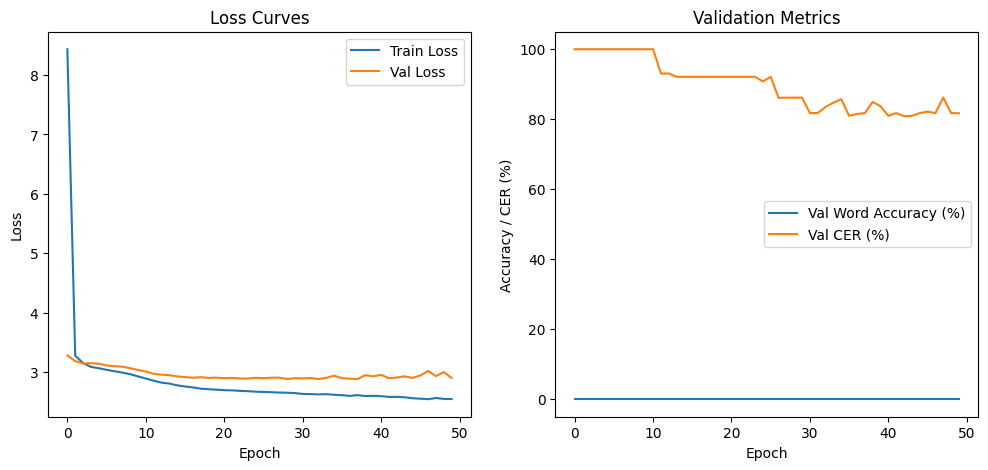


Test Loss: 2.7066, Test Word Accuracy: 0.00%, Test CER: 0.8173

Sample Predictions on Test Set:
GT: 9ql9stqd | Predicted: bd
GT: a9bjo9bj | Predicted: bnd
GT: ahqsgc9x | Predicted: bnd
GT: ahqsgc9x | Predicted: bd
GT: 9clhq9k | Predicted: bd
GT: aqnbgtqd | Predicted: bd
GT: bnmrhrs | Predicted: bnd
GT: bnllhsldms | Predicted: bnd
GT: aqnbgtqd | Predicted: bnd
GT: atqfk9qx | Predicted: bd


In [42]:
########################################
# 1. Define Character Set and Mappings
########################################
character_set = "0123456789abcdefghijklmnopqrstuvwxyz"
# Reserve index 0 for CTC blank.
char_to_index = {char: i+1 for i, char in enumerate(character_set)}
index_to_char = {i+1: char for char, i in char_to_index.items()}
num_chars = len(character_set) + 1  # Including blank

########################################
# 2. Dataset Splitting (Your Existing Code)
########################################
# Assume dataset_info is already created from easy_dataset and hard_dataset:
# Each sample: {'image_path': path, 'label': word, 'set': 'easy' or 'hard'}
print("Total samples:", len(dataset_info))

train_ratio = 0.7
val_ratio = 0.15

easy_samples = [sample for sample in dataset_info if sample['set'] == 'easy']
hard_samples = [sample for sample in dataset_info if sample['set'] == 'hard']

def split_subset(samples, train_ratio):
    from sklearn.model_selection import train_test_split
    train_samples, temp_samples = train_test_split(samples, test_size=(1 - train_ratio), random_state=42)
    val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)
    return train_samples, val_samples, test_samples

train_easy, val_easy, test_easy = split_subset(easy_samples, train_ratio)
train_hard, val_hard, test_hard = split_subset(hard_samples, train_ratio)

train_set = train_easy + train_hard
val_set   = val_easy   + val_hard
test_set  = test_easy  + test_hard

random.shuffle(train_set)
random.shuffle(val_set)
random.shuffle(test_set)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

########################################
# 3. Define the OCR Dataset Class for CRNN
########################################
class OCRDataset(Dataset):
    def __init__(self, data, transform=None, char_to_index=None):
        """
        data: list of dicts with keys 'image_path', 'label' (full text), 'set'
        transform: torchvision transforms to apply on the image.
        char_to_index: dictionary mapping characters to indices.
        """
        self.data = data
        self.transform = transform
        self.char_to_index = char_to_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert text to lower-case and then to indices.
        text = sample['label'].lower()
        target_indices = [self.char_to_index.get(c, 0) for c in text]
        target_tensor = torch.tensor(target_indices, dtype=torch.long)
        return image, target_tensor

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0 if x.max() > 1 else x)
])

# Create datasets
train_dataset = OCRDataset(train_set, transform=transform, char_to_index=char_to_index)
val_dataset   = OCRDataset(val_set,   transform=transform, char_to_index=char_to_index)
test_dataset  = OCRDataset(test_set,  transform=transform, char_to_index=char_to_index)

########################################
# 4. Define DataLoader with collate_fn for variable-length targets
########################################
def ocr_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    # Keep targets as list of tensors
    return images, list(targets)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=ocr_collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=ocr_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=ocr_collate_fn)

########################################
# 5. Define the CRNN Model with CTC
########################################
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, hidden_size=256):
        """
        img_height: height of input images.
        num_channels: number of channels (3 for RGB).
        num_classes: number of output classes (including blank).
        hidden_size: hidden size for LSTM layers.
        """
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  # (B,64,H/2,W/2)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),  # (B,128,H/4,W/4)
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # (B,256,H/8,W/4)
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))   # (B,512,H/16,W/4)
        )
        
        self.rnn1 = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # x: (B, 3, H, W)
        conv_out = self.cnn(x)  # (B,512,H',W')
        b, c, h, w = conv_out.size()
        if h != 1:
            conv_out = F.adaptive_avg_pool2d(conv_out, (1, w))
        conv_out = conv_out.squeeze(2)  # (B,512,W)
        conv_out = conv_out.permute(0, 2, 1)  # (B, W, 512) treat W as time
        rnn_out, _ = self.rnn1(conv_out)      # (B, W, hidden*2)
        rnn_out, _ = self.rnn2(rnn_out)         # (B, W, hidden*2)
        logits = self.fc(rnn_out)             # (B, W, num_classes)
        logits = logits.permute(1, 0, 2)        # (T, B, num_classes) for CTCLoss
        return logits

########################################
# 6. Define Scientific Evaluation Metrics
########################################
# We define a simple Levenshtein distance function for CER.
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1  
            deletions = current_row[j] + 1        
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def compute_CER(pred, target):
    # Character Error Rate = Levenshtein distance / len(target)
    if len(target) == 0:
        return 1.0
    return levenshtein(pred, target) / len(target)

########################################
# 7. Training and Evaluation Functions
########################################
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_samples = 0
    for images, targets in loader:
        images = images.to(device)
        # Prepare targets: concatenate and record lengths.
        target_lengths = [len(t) for t in targets]
        targets_concat = torch.cat(targets).to(device)
        batch_size = images.size(0)
        
        optimizer.zero_grad()
        outputs = model(images)  # (T, B, num_classes)
        log_probs = F.log_softmax(outputs, dim=2)
        T = outputs.size(0)
        input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
        target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)
        
        loss = criterion(log_probs, targets_concat, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    return total_loss / total_samples

def validate(model, loader, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            target_lengths = [len(t) for t in targets]
            targets_concat = torch.cat(targets).to(device)
            batch_size = images.size(0)
            
            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)
            T = outputs.size(0)
            input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
            target_lengths_tensor = torch.tensor(target_lengths, dtype=torch.long).to(device)
            
            loss = criterion(log_probs, targets_concat, input_lengths, target_lengths_tensor)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Greedy decoding:
            max_indices = torch.argmax(outputs, dim=2)  # (T, B)
            max_indices = max_indices.transpose(0, 1)     # (B, T)
            for i in range(batch_size):
                pred_seq = []
                prev = 0
                for idx in max_indices[i]:
                    idx = idx.item()
                    if idx != 0 and idx != prev:
                        pred_seq.append(index_to_char.get(idx, ''))
                    prev = idx
                pred_text = "".join(pred_seq)
                all_preds.append(pred_text)
                
                target_text = "".join([index_to_char.get(idx.item(), '') for idx in targets[i]])
                all_targets.append(target_text)
    
    avg_loss = total_loss / total_samples
    word_accuracy = 100.0 * sum(p == t for p, t in zip(all_preds, all_targets)) / len(all_targets)
    
    # Compute average CER.
    cer_list = [compute_CER(p, t) for p, t in zip(all_preds, all_targets)]
    avg_cer = sum(cer_list) / len(cer_list)
    
    return avg_loss, word_accuracy, avg_cer, all_preds, all_targets

########################################
# 8. Main Training Loop and Scientific Evaluation
########################################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Instantiate the model.
    img_height = 64
    num_channels = 3
    hidden_size = 256
    model = CRNN(img_height, num_channels, num_chars, hidden_size=hidden_size).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    num_epochs = 50
    train_losses = []
    val_losses = []
    val_word_acc = []
    val_cer = []
    
    for epoch in range(num_epochs):
        tr_loss = train_one_epoch(model, train_loader, optimizer, device)
        v_loss, v_acc, v_cer, v_preds, v_targets = validate(model, val_loader, device)
        train_losses.append(tr_loss)
        val_losses.append(v_loss)
        val_word_acc.append(v_acc)
        val_cer.append(v_cer)
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss={tr_loss:.4f}, Val Loss={v_loss:.4f}, "
              f"Val Word Acc={v_acc:.2f}%, Val CER={v_cer:.4f}")
    
    # Plot learning curves.
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curves")
    
    plt.subplot(1,2,2)
    plt.plot(val_word_acc, label='Val Word Accuracy (%)')
    plt.plot([100*x for x in val_cer], label='Val CER (%)')  # multiply CER by 100 for percentage display
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / CER (%)')
    plt.legend()
    plt.title("Validation Metrics")
    plt.show()
    
    # Evaluate on the test set.
    test_loss, test_acc, test_cer, test_preds, test_targets = validate(model, test_loader, device)
    print(f"\nTest Loss: {test_loss:.4f}, Test Word Accuracy: {test_acc:.2f}%, Test CER: {test_cer:.4f}")
    
    # Print a few sample predictions.
    print("\nSample Predictions on Test Set:")
    for i in range(min(10, len(test_preds))):
        print(f"GT: {test_targets[i]} | Predicted: {test_preds[i]}")
    
    # Save the scientific evaluation metrics to a file (optional).
    np.savez("evaluation_metrics.npz", 
             train_losses=train_losses, 
             val_losses=val_losses, 
             val_word_acc=val_word_acc, 
             val_cer=val_cer,
             test_loss=test_loss,
             test_acc=test_acc,
             test_cer=test_cer)
    
if __name__ == '__main__':
    main()

# Bonus

Total bonus samples: 126
Train set size: 88
Validation set size: 19
Test set size: 19
Using device: cuda
Epoch 1/50: Train Loss=11.0920, Val Loss=4.0959, Val Word Acc=0.00%
Epoch 2/50: Train Loss=3.6565, Val Loss=3.3117, Val Word Acc=0.00%
Epoch 3/50: Train Loss=3.2616, Val Loss=2.9963, Val Word Acc=0.00%
Epoch 4/50: Train Loss=3.1027, Val Loss=3.0174, Val Word Acc=0.00%
Epoch 5/50: Train Loss=3.0464, Val Loss=2.9863, Val Word Acc=0.00%
Epoch 6/50: Train Loss=3.0413, Val Loss=2.9795, Val Word Acc=0.00%
Epoch 7/50: Train Loss=3.0118, Val Loss=2.9702, Val Word Acc=0.00%
Epoch 8/50: Train Loss=3.0064, Val Loss=2.9508, Val Word Acc=0.00%
Epoch 9/50: Train Loss=2.9866, Val Loss=2.9297, Val Word Acc=0.00%
Epoch 10/50: Train Loss=2.9724, Val Loss=2.9110, Val Word Acc=0.00%
Epoch 11/50: Train Loss=2.9554, Val Loss=2.8927, Val Word Acc=0.00%
Epoch 12/50: Train Loss=2.9341, Val Loss=2.8733, Val Word Acc=0.00%
Epoch 13/50: Train Loss=2.8978, Val Loss=2.8548, Val Word Acc=0.00%
Epoch 14/50: Train 

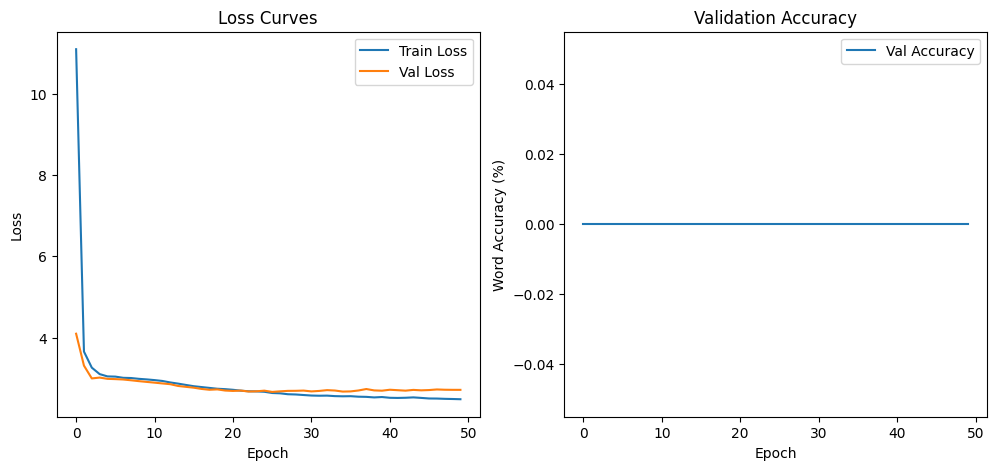


Test Loss=2.7578, Test Word Acc=0.00%

Sample Predictions on Test Set:
GT: atqfk9qx | Pred: bnd
GT: 9mshcnsd | Pred: bnd
GT: bnmudmd | Pred: bn
GT: 9rrdlakx | Pred: bnd
GT: akhyy9qc | Pred: bn


In [43]:
# Character set: digits + lowercase letters (example)
character_set = "0123456789abcdefghijklmnopqrstuvwxyz"
# Index 0 is reserved for the CTC blank token
char_to_index = {char: i+1 for i, char in enumerate(character_set)}
index_to_char = {i+1: char for char, i in char_to_index.items()}
num_chars = len(character_set) + 1  # +1 for the blank

dataset_info = []
for word, path in bonus_dataset.items():
    # 'bonus' set is just a tag, it won't affect the model but may help debugging
    dataset_info.append({
        'image_path': path,
        'label': word,
        'set': 'bonus'
    })

print("Total bonus samples:", len(dataset_info))

train_ratio = 0.7
def split_subset(samples, train_ratio):
    train_samples, temp_samples = train_test_split(samples, test_size=(1 - train_ratio), random_state=42)
    val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)
    return train_samples, val_samples, test_samples

train_set, val_set, test_set = split_subset(dataset_info, train_ratio)

random.shuffle(train_set)
random.shuffle(val_set)
random.shuffle(test_set)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

class OCRDataset(Dataset):
    def __init__(self, data, transform=None, char_to_index=None):
        """
        data: list of dicts with keys: 'image_path', 'label', 'set'
        transform: transforms to apply on the image
        char_to_index: dictionary mapping each character to an integer
        """
        self.data = data
        self.transform = transform
        self.char_to_index = char_to_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # The label is the original word, regardless of whether the text is reversed in the image
        text = sample['label'].lower()
        # Convert characters to indices
        target_indices = [self.char_to_index.get(ch, 0) for ch in text]
        target_tensor = torch.tensor(target_indices, dtype=torch.long)
        return image, target_tensor

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 256)),    # Example size
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0 if x.max() > 1 else x)
])

# Create dataset objects
train_dataset = OCRDataset(train_set, transform=transform, char_to_index=char_to_index)
val_dataset   = OCRDataset(val_set,   transform=transform, char_to_index=char_to_index)
test_dataset  = OCRDataset(test_set,  transform=transform, char_to_index=char_to_index)

def ocr_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, list(targets)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=ocr_collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=ocr_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=ocr_collate_fn)

class CRNN(nn.Module):
    def __init__(self, img_height=64, num_channels=3, num_classes=37, hidden_size=256):
        """
        img_height: The height of your input images (64 as an example).
        num_channels: The number of channels (3 for RGB).
        num_classes: The total number of characters (including blank).
        hidden_size: The dimension of the LSTM hidden state.
        """
        super(CRNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # height halved, width same
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))   # further reduce height
        )
        
        self.rnn1 = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # x: (B, 3, H, W)
        conv_out = self.cnn(x)  # (B, 512, H', W')
        b, c, h, w = conv_out.size()
        if h != 1:
            # reduce or pool if needed
            conv_out = F.adaptive_avg_pool2d(conv_out, (1, w))
        conv_out = conv_out.squeeze(2)   # (B, 512, W)
        conv_out = conv_out.permute(0, 2, 1)  # (B, W, 512)
        
        rnn_out, _ = self.rnn1(conv_out)  # (B, W, hidden*2)
        rnn_out, _ = self.rnn2(rnn_out)   # (B, W, hidden*2)
        
        logits = self.fc(rnn_out)         # (B, W, num_classes)
        # For CTCLoss: (T, B, C)
        logits = logits.permute(1, 0, 2)  # (W, B, num_classes)
        return logits


criterion = nn.CTCLoss(blank=0, zero_infinity=True)

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_samples = 0
    
    for images, targets in loader:
        images = images.to(device)
        # Build target lengths
        target_lengths = [len(t) for t in targets]
        targets_concat = torch.cat(targets).to(device)  # 1D
        batch_size = images.size(0)
        
        optimizer.zero_grad()
        
        outputs = model(images)  # (T, B, num_classes)
        log_probs = F.log_softmax(outputs, dim=2)
        T = outputs.size(0)  # "time" dimension (width after CNN)
        input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
        target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)
        
        loss = criterion(log_probs, targets_concat, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    return total_loss / total_samples

def validate(model, loader, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            target_lengths = [len(t) for t in targets]
            targets_concat = torch.cat(targets).to(device)
            batch_size = images.size(0)
            
            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)
            T = outputs.size(0)
            input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
            target_lengths_tensor = torch.tensor(target_lengths, dtype=torch.long).to(device)
            
            loss = criterion(log_probs, targets_concat, input_lengths, target_lengths_tensor)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Greedy decoding
            max_indices = torch.argmax(outputs, dim=2)  # (T, B)
            max_indices = max_indices.transpose(0, 1)   # (B, T)
            for i in range(batch_size):
                pred_seq = []
                prev_idx = 0
                for idx in max_indices[i]:
                    idx = idx.item()
                    if idx != 0 and idx != prev_idx:
                        pred_seq.append(index_to_char.get(idx, ''))
                    prev_idx = idx
                all_preds.append("".join(pred_seq))
                
                # Convert numeric target back to text for comparison
                true_chars = []
                for idx_t in targets[i]:
                    if idx_t.item() != 0:
                        true_chars.append(index_to_char.get(idx_t.item(), ''))
                all_targets.append("".join(true_chars))
    
    avg_loss = total_loss / total_samples
    correct = sum([1 for p, t in zip(all_preds, all_targets) if p == t])
    word_acc = 100.0 * correct / len(all_preds)
    
    return avg_loss, word_acc, all_preds, all_targets


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CRNN(img_height=64, num_channels=3, num_classes=num_chars, hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc, preds, targets = validate(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, "
          f"Val Loss={val_loss:.4f}, "
          f"Val Word Acc={val_acc:.2f}%")

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Word Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc, test_preds, test_targets = validate(model, test_loader, device)
print(f"\nTest Loss={test_loss:.4f}, Test Word Acc={test_acc:.2f}%")

# Print some sample predictions
print("\nSample Predictions on Test Set:")
for i in range(min(5, len(test_preds))):
    print(f"GT: {test_targets[i]} | Pred: {test_preds[i]}")
